# ITC 6001 - PROJECT - Introduction To Big Data #
## Drouvas Panagiotis, Dendrinos Theodoros, Kontoudakis Nikolaos ##

In [44]:
# import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
print(os.getcwd());
# change the following on your pc!
# projectPath = "/home/nikos/Documents/6001_project"
projectPath = "./"
dataPath = projectPath + "/ml-100k/u.data"
userPath = projectPath + "/ml-100k/u.user";

#outlier sigma limit
oSL= 3

/home/nikos/Documents/6001_project


# Q1: Exploring the Data

## Read the data

In [76]:
uData = pd.read_csv(dataPath, sep= '\t', header= None, names=["userId", "itemId", "rating", "timestamp"])
uUser = pd.read_csv(userPath, sep= '|', header= None, names=['userId', 'age', 'gender', 'occupation', 'zip_code']).drop(columns =  ['occupation', 'zip_code']).set_index(keys="userId", drop= "True")
pivotedData = uData.pivot(index="userId", columns="itemId", values="rating").reset_index().rename_axis(None, axis=1).set_index(keys="userId", drop= "True")
#make it easier to access the column names
pivotedData.columns = pivotedData.columns.map(str)
# pivotedData = pivotedData.sample(frac=0.01,random_state=100, axis= 0)

In [78]:
# #free testing area

# display(pivotedData[pivotedData.userId== 916])
# pivotedData.to_csv("export.csv", sep=',', encoding='utf-8', index=False, header=True)
# diferentPivotMovies = uData.pivot(index="itemId", columns="userId", values="rating").reset_index().rename_axis(None, axis=1)
# display(pivotedData)
# print(diferentPivotMovies)

# uData[uData.userId == 943].sum()
# pivotedData.loc[[943]].sum(axis=1)

## Remove outliers ##

In [81]:
# for movies
movieRatingsCount = pivotedData.notna().sum(axis= 0)
movieRatingCountMu = np.mean(movieRatingsCount)
movieRatingSigma = np.std(movieRatingsCount)
ZMovieScore = ((movieRatingsCount - movieRatingCountMu)) / movieRatingSigma
lessThan10 = movieRatingsCount < 9

In [83]:
# for users
ratingsCount = pivotedData.notna().sum(axis= 1)
mu = np.mean(ratingsCount)
sigma = np.std(ratingsCount)
pivotedData['ZScore'] = ((ratingsCount - mu) / sigma)

#z scores for both movies and users have been calculated in advance in order to be fair.
#otherwise if we droped some users and later calculating the movie ZScore we would also drop their ratings which would result in mistakenly calculating some movies as outliers 
removedOutliers = pivotedData[(pivotedData.ZScore > -oSL) & (pivotedData.ZScore < oSL)].drop(columns= ["ZScore"])
movieOutliers = ZMovieScore[(ZMovieScore < -oSL) | (ZMovieScore > oSL)].index
lessThan10Indexes = lessThan10[lessThan10].index
# Drop the columns from the DataFrame
removedOutliers = removedOutliers.drop(columns=movieOutliers, axis=1)
removedOutliers = removedOutliers.drop(columns=lessThan10Indexes, axis=1)

## Information ##

In [86]:
removedOutliers.describe()
# pivotedData.to_csv("original.csv", sep=',', encoding='utf-8', index=False, header=True)

,2,3,4,5,6,8,9,10,11,12,...,1471,1473,1478,1480,1483,1503,1518,1540,1615,1620
count,120.000000,83.000000,197.000000,79.000000,23.000000,210.000000,291.000000,83.00000,225.000000,255.000000,...,7.000000,8.00000,15.000000,8.000000,10.000000,8.000000,10.000000,8.00000,10.000000,9.000000
mean,3.208333,3.060241,3.543147,3.367089,3.739130,3.995238,3.893471,3.86747,3.871111,4.407843,...,2.714286,3.62500,2.866667,2.125000,3.400000,3.250000,3.000000,2.75000,3.000000,3.222222
std,0.969240,1.243023,0.971227,0.922333,1.214211,1.009513,1.046666,1.02137,1.054883,0.787662,...,1.112697,1.30247,0.990430,1.125992,1.173788,1.035098,0.816497,1.28174,1.054093,1.201850
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,2.000000,2.000000,1.00000,1.000000,1.000000
25%,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.00000,3.000000,4.000000,...,2.000000,3.00000,2.500000,1.000000,3.000000,2.750000,2.250000,2.00000,2.250000,3.000000
50%,3.000000,3.000000,4.000000,3.000000,4.000000,4.000000,4.000000,4.00000,4.000000,5.000000,...,3.000000,4.00000,3.000000,2.000000,4.000000,3.000000,3.000000,2.50000,3.000000,3.000000
75%,4.000000,4.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,...,3.500000,4.25000,3.500000,3.000000,4.000000,4.000000,3.750000,3.25000,4.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,...,4.000000,5.00000,4.000000,4.000000,5.000000,5.000000,4.000000,5.00000,4.000000,5.000000


## Ploting ##
 plot the number of movies seen by each user, and the frequency of each rating

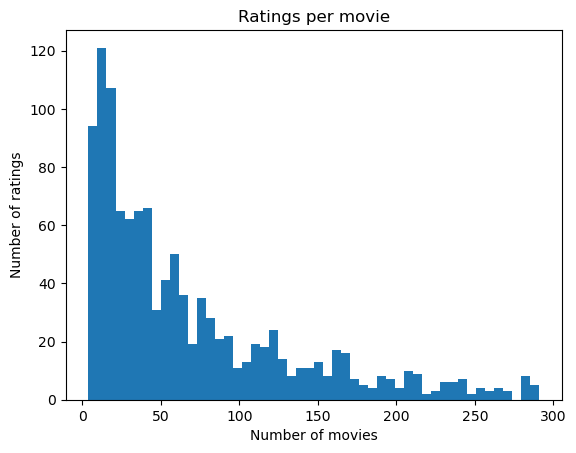

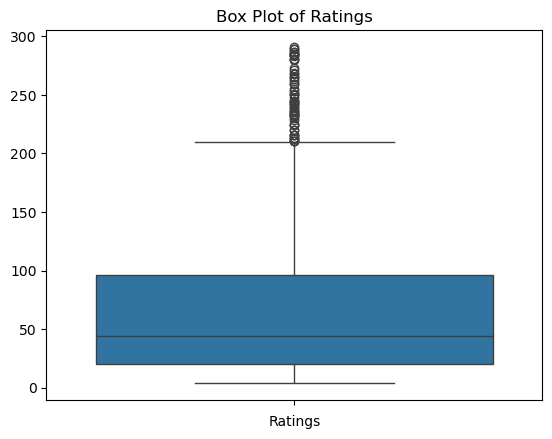

In [104]:
plt.title('Ratings per movie')
plt.xlabel("Number of movies")
plt.ylabel("Number of ratings")
plt.hist(removedOutliers.count(), bins= 50)

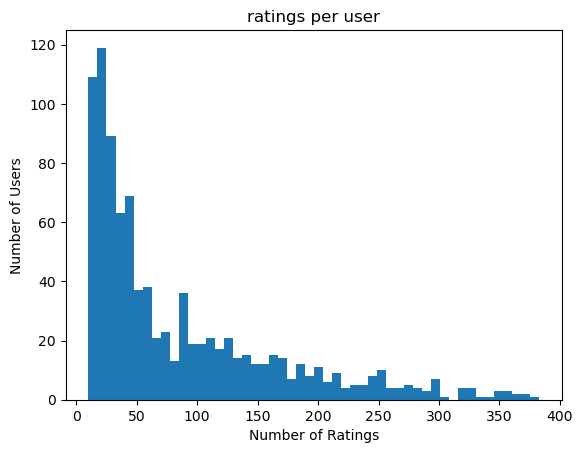

In [100]:
ratingsPerUser = removedOutliers.notnull().sum(axis=1)

ratingsPerUser.hist(bins=50)
plt.title('ratings per user')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.grid(False)
plt.show()



# Q2: Basic Recommended System

## Spliting data into train and test ##

In [ ]:
#random_state property allows for repitability of the spliting
trainData= removedOutliers.sample(frac=0.8,random_state=200, axis= 0)
testData= removedOutliers.drop(trainData.index)

In [ ]:
#get the number of ratings a movie has
trainDataRatingsCount = trainData.notna().sum(axis= 0)
trainData

## Recomend movies to test users

In [ ]:
# we recommend for each user seperately in order to be more flexible with the calculations

averageMovieRating = trainData.mean().sort_values(ascending= False)
recommendedMovies = pd.DataFrame()
for userIndex, row in testData.iterrows():  
    # if we want to recomend allready seen movies
    # notNanCols = row.dropna().index
    # sortedCols = averageMovieRating[notNanCols].sort_values(ascending=False).index[:10]
    
    #recommend the top 10 movies
    sortedCols = averageMovieRating.index[:10]
    topValues = averageMovieRating[sortedCols].values
    recommendedMovies.loc[userIndex, sortedCols] = topValues

# remove the warning
pd.set_option("future.no_silent_downcasting", True)
recommendedMovies = recommendedMovies.replace(b'', np.nan)
# testData.to_csv("testData.csv", sep=',', encoding='utf-8', index=True, header=True)
# averageMovieRating.to_csv("AMR.csv", sep=',', encoding='utf-8', index=True, header=True)
# recommendedMovies.to_csv("recommended.csv", sep=',', encoding='utf-8', index=True, header=True)

# Evaluate results using MAE, RMSE, precision, recall, and F1.

In [ ]:
# calculate only for the values we predicted
alignedObservedDf, alignedCalculatedDF = testData.align(recommendedMovies)
validMask = ~alignedCalculatedDF.isna()
# validMask.to_csv("validMask.csv", sep=',', encoding='utf-8', index=True, header=True)
# remove NaN values
validOriginal = alignedObservedDf[validMask]
validCalculated = alignedCalculatedDF[validMask]


## MAE

In [ ]:
# mean two times for the two axis
MAE = np.abs(validOriginal - validCalculated).mean().mean()
MAE

## RMSE

In [ ]:
meanSquaredError = ((validCalculated - validOriginal) ** 2).mean().mean()
RMSE = np.sqrt(meanSquaredError)
RMSE

In [ ]:
# calculate precision and recall nominator.
# seen movies that were recommended and the user rated them > 3.
wellRated = testData[testData >= 3]
alignedWellRated, alignedRecommended = wellRated.align(recommendedMovies)
validWellRatedMask = ~alignedWellRated.isna()
validRecommended = alignedRecommended[validWellRatedMask]

## Precision

In [ ]:
precision = (validRecommended.notna().sum(axis= 1)/10).mean()
precision

## Recall

In [ ]:
recall = (validRecommended.notna().sum(axis= 1)/wellRated.notna().sum(axis= 1)).mean()
recall

## F1 Score

In [ ]:
f1Score = 2* ((precision* recall)/(precision+ recall))
f1Score

# Q3: Collaborative Filtering: Recommender system

In [ ]:
#libraries 


# Dbg = open("./DebugFile_cosineSimilarity.txt", "w")   # for debug file - to be deleted
# Dbg.write(' > > >  initiate')
# Dbg.close()
# Dbg =  open("./DebugFile_createSimilarityMatrix.txt", "w")   # for debug file - to be deleted
# Dbg.write(' > > >  initiate')
# Dbg.close()
# Dbg =  open("./DebugFile_predictR.txt", "w")   # for debug file - to be deleted
# Dbg.write(' > > >  initiate')
# Dbg.close()



def cosineSimilarity(u1, u2):
    #Find similarity between u1,u2 (two vectors - representing users) by finding the cosine of the angle between them
    #cosine = cosine is the ratio of the length of the adjacent side to that of the hypotenuse of a right angle triangle
    #similarity based on cosine -> 
    # dot product of vectors divaded by the product of the magmitudes 

    # Dbg =  open("DebugFile_cosineSimilarity.txt", "a")   # for debug file - to be deleted 
    # Dbg.write('\n')
    # Dbg.write('\n ----cosineSimilarity---------')
    # Dbg.write('\n u1,u2 => ' + str(u1) + ' , ' + str(u2))
    # Dbg.write('\n dot => ' + str(np.dot(u1, u2)))
    # Dbg.write('\n Hypotenus u1,u2 => ' + str(np.linalg.norm(u1)) + ' ... ' + str(np.linalg.norm(u2)))      
    # Dbg.write('\n ===============================')
    if (np.linalg.norm(u1) * np.linalg.norm(u2)) == 0 :
        # Dbg.write('\n !!!! Divide by zero !!!!!')
        return 9999999
    else:    
        return np.dot(u1, u2) / (np.linalg.norm(u1) * np.linalg.norm(u2))

    # Dbg.close()

# Similarity matrix
def createSimilarityMatrix(df):
    #create couple of users (all combinations) and calculate with cosin similarity all cobinations

    # Dbg =  open("DebugFile_createSimilarityMatrix.txt", "a")   # for debug file - to be deleted
    # Dbg.write('\n')
    
    similarityMatrix = pd.DataFrame(index=df.index, columns=df.index) # output
    #iterate in all combinations
    for i in df.index: 
        for k in df.index:
            #similarityMatrix.loc[i, k] = cosineSimilarity(df.loc[i].fillna(0), df.loc[k].fillna(0))
            if i == k:
                similarityMatrix.loc[i, k] = 1 # for the combination of the same user similarity is 1 by definition 
                # Dbg.write ('\n @ ' + str(i) + ',' + str(k) + ' = ' + str(similarityMatrix.loc[i, k] ) + ' => 1 by definition') # ->> to be commened
            else:
                # Dbg.write ('\n @ ' + str(i) + ',' + str(k) + ' = ' + str(similarityMatrix.loc[i, k] ) + ' => ' + str(cosineSimilarity(df.loc[i].fillna(0), df.loc[k].fillna(0)))) # ->> to be commened
                similarityMatrix.loc[i, k] = cosineSimilarity(df.loc[i].fillna(0), df.loc[k].fillna(0))
    # Dbg.close()            
    return similarityMatrix    


# Predict Ratings based on wated waited sum of all users rating for the movie
def predictR(df, similarityMatrix):
    # Dbg =  open("DebugFile_predictR.txt", "a")   # for debug file - to be deleted
    # Dbg.write('\n')
    
    predictRatings = df.copy() #create a copy for predictions
    for user in df.index:
        for movie in df.columns:
            if np.isnan(df.loc[user, movie]):
                similarU = similarityMatrix[user].drop(user).dropna() #check similarity with others - delete similarity with himself and any nulls
                similarU = similarU[similarU > 0] #keep positive similarity
                if not similarU.empty: #if similarity exists
                    weightedS = sum(df.loc[similarU.index, movie] * similarU) #calculates the waited sum of all users rating for the movie
                    # Dbg.write('\n @ ' + user + ',' + movie + ' => ' +str(weightedS))
                    similarityS = sum(similarU) #total similarities (to be used in the division)
                    predictRatings.loc[user, movie] = weightedS / similarityS #prediction based on the weighted sum of the ratings divided by the sum of the similarity scores
    # Dbg.close()
    return predictRatings

# Top x recommendations for each user
def topXrecommendations(predictRatings, x):
    recomm = {}
    for user in predictRatings.index:
        userR = predictRatings.loc[user]
        userR = userR[userR.notna()]
        topRecomm = userR.sort_values(ascending=False).head(x)
        recomm[user] = topRecomm.index.tolist()
    return recomm

def Find20ofData2Hide(Random20Hiden):
    # Selecting a random 20% of non-NaN values and returns "True" to "hide" them (all othe valuse are false
    
    # Selecting only non-NaN values
    NonNaNValues = Random20Hiden.stack().reset_index(drop=False)
    # Calculate the number of samples to select (20% of the non-NaN values to hide)
    num_samples = int(0.2 * len(NonNaNValues))
    
    # Select a random sample of the non-NaN values
    # random_state property allows for repeatability of the splitting
    random_sample20_indices = NonNaNValues.sample(n=num_samples, random_state=200).index

    #initialize dataframe with false
    Random20Hiden = pd.DataFrame(False,index = Random20Hiden.index, columns = Random20Hiden.columns)
    
    # Set the selected values to NaN (Hide them from system)
    for idx in random_sample20_indices:
        row_idx = NonNaNValues.loc[idx, 'userId']
        col_idx = NonNaNValues.loc[idx, 'level_1']
        Random20Hiden.at[row_idx, col_idx] = True
        
    return Random20Hiden



def findKSimilar (r, k,printx =False):
    # Find the k-most similar users for each user
    #
    # r is the ratings matrix
    # k is the number of most similar users
    #
    # returns: '
    #similarUsers: contains the indices of the most similar users to each user
    # similarities: is the pairwise similarities, i.e. similarities between users
    
    # similarUsers is 2-D matrix
    similarUsers=-1*np.ones((nUsers,k))
    
    similarities=cosine_similarity(r)
       
    # for each user
    
    # find the indexes of all  users similar to i, by increasing value of similarity
    for i in range(0, nUsers):
        simUsersIdxs= np.argsort(similarities[:,i])
        
        l=0
        #find its most similar users    
        for j in range(simUsersIdxs.size-2, simUsersIdxs.size-1-k-1,-1):
            if printx :
                    print(simUsersIdxs[-k+1:],l)
            similarUsers[i,l]=simUsersIdxs[j]
            l=l+1
            
    return similarUsers, similarities

def Top5RatedMovies(UserMovies):
    # it finds average rating of each movie and returns top 5 rated movies

    #calculate average per movie
    UserMoviesAVG = UserMovies[UserMovies.notna()].sum() / UserMovies[UserMovies.notna() ].count()
    

    

In [ ]:
# Verification Libraries

def MAE(Original,Calculated,x,y):
    return np.abs(validOriginal[x:y] - validCalculated[x:y]).mean().mean()

def RMSE(Original,Calculated,x,y):
    meanSquaredError = ((validOriginal[x:y] - validCalculated[x:y]) ** 2).mean().mean()
    return np.sqrt(meanSquaredError)

#def precision(Original,Calculated,x,y):
#    precision = (validRecommended.notna().sum(axis= 1)/10).mean()
#    precision

#def recall(Original,Calculated,x,y):
#    recall = (validRecommended.notna().sum(axis= 1)/wellRated.notna().sum(axis= 1)).mean()
#    recall

#def f1Score():
#    f1Score = 2* ((precision* recall)/(precision+ recall))
#    f1Score

def Hide20Data(OriginalRating,IsHideDataframe):
    #returns a datafram with nan in evry cell that is hidden
    OriginalRating[IsHideDataframe] = np.nan

    return OriginalRating
 

In [ ]:
#create test data

data = {
    'User1': [5, 2, 2, np.nan, np.nan],
    'User2': [np.nan, np.nan, np.nan, np.nan, np.nan],
    'User3': [4, 3, np.nan, np.nan, 5],
    'User4': [1, 2, np.nan, np.nan, 1],
    'User5': [1, 5, 5, np.nan, 1]
}
df = pd.DataFrame(data, index=['Movie1', 'Movie2', 'Movie3', 'Movie4', 'Movie5']).T

print('initial = ')
print(df)
print('final  = ')
isH= Find20ofData2Hide(df)
print(isH)
print('=====================')
print(Hide20Data(df,isH))





      
#print(Top5RatedMovies(df))

#similarity_matrix = createSimilarityMatrix(df) # Create similarity matrix


#predicted_ratings = predictR(df, similarity_matrix) # Predict ratings


#top_recommendations = topXrecommendations(predicted_ratings, 3) # Get top 3 recommendations for each user

#print("Original Ratings:")
#print(df)
#print("\nPredicted Ratings:")
#print(predicted_ratings)
#print("\nTop 3 Recommendations for Each User:")
#print(top_recommendations)




## 1.The collaborative system will be based on user similarity

In [ ]:
# Predict Ratings based on wated waited sum of all users rating for the movie
def predictR(df, similarityMatrix):
    #Dbg =  open("DebugFile_predictR.txt", "a")   # for debug file - to be deleted
    #Dbg.write('\n')
    
    predictRatings = df.copy() #create a copy for predictions
    for user in df.index:
        for movie in df.columns:
            if np.isnan(df.loc[user, movie]):
                similarU = similarityMatrix[user].drop(user).dropna() #check similarity with others - delete similarity with himself and any nulls
                similarU = similarU[similarU > 0] #keep positive similarity
                if not similarU.empty: #if similarity exists
                    weightedS = sum(df.loc[similarU.index, movie] * similarU) #calculates the waited sum of all users rating for the movie
                    #Dbg.write('\n @ ' + user + ',' + movie + ' => ' +str(weightedS))
                    similarityS = sum(similarU) #total similarities (to be used in the division)
                    predictRatings.loc[user, movie] = weightedS / similarityS #prediction based on the weighted sum of the ratings divided by the sum of the similarity scores
    #Dbg.close()
    return predictRatings

# Top x recommendations for each user
def topXrecommendations(predictRatings, x):
    recomm = {}
    for user in predictRatings.index:
        userR = predictRatings.loc[user]
        userR = userR[userR.notna()]
        topRecomm = userR.sort_values(ascending=False).head(x)
        recomm[user] = topRecomm.index.tolist()
    return recomm

## 2.User based similarity will be based on cosine similarity

In [ ]:
def cosineSimilarity(u1, u2):
    #Find similarity between u1,u2 (two vectors - representing users) by finding the cosine of the angle between them
    #cosine = cosine is the ratio of the length of the adjacent side to that of the hypotenuse of a right angle triangle
    #similarity based on cosine -> 
    # dot product of vectors divaded by the product of the magmitudes 

    #Dbg =  open("DebugFile_cosineSimilarity.txt", "a")   # for debug file - to be deleted 
    #Dbg.write('\n')
    #Dbg.write('\n ----cosineSimilarity---------')
    #Dbg.write('\n u1,u2 => ' + str(u1) + ' , ' + str(u2))
    #Dbg.write('\n dot => ' + str(np.dot(u1, u2)))
    #Dbg.write('\n Hypotenus u1,u2 => ' + str(np.linalg.norm(u1)) + ' ... ' + str(np.linalg.norm(u2)))      
    #Dbg.write('\n ===============================')
    if (np.linalg.norm(u1) * np.linalg.norm(u2)) == 0 :
        #Dbg.write('\n !!!! Divide by zero !!!!!')
        return 9999999
    else:    
        return np.dot(u1, u2) / (np.linalg.norm(u1) * np.linalg.norm(u2))

    #Dbg.close()

# Similarity matrix
def createSimilarityMatrix(df):
    #create couple of users (all combinations) and calculate with cosin similarity all cobinations

    #Dbg =  open("DebugFile_createSimilarityMatrix.txt", "a")   # for debug file - to be deleted
    #Dbg.write('\n')
    
    similarityMatrix = pd.DataFrame(index=df.index, columns=df.index) # output
    #iterate in all combinations
    for i in df.index: 
        for k in df.index:
            #similarityMatrix.loc[i, k] = cosineSimilarity(df.loc[i].fillna(0), df.loc[k].fillna(0))
            if i == k:
                similarityMatrix.loc[i, k] = 1 # for the combination of the same user similarity is 1 by definition 
                #Dbg.write ('\n @ ' + str(i) + ',' + str(k) + ' = ' + str(similarityMatrix.loc[i, k] ) + ' => 1 by definition') # ->> to be commened
            else:
                #Dbg.write ('\n @ ' + str(i) + ',' + str(k) + ' = ' + str(similarityMatrix.loc[i, k] ) + ' => ' + str(cosineSimilarity(df.loc[i].fillna(0), df.loc[k].fillna(0)))) # ->> to be commened
                similarityMatrix.loc[i, k] = cosineSimilarity(df.loc[i].fillna(0), df.loc[k].fillna(0))
    #Dbg.close()            
    return similarityMatrix    

## 3.Generate the top-5 recommendations per user

In [ ]:
similarity_matrix = createSimilarityMatrix(removedOutliers.sample(frac=0.1,random_state=200, axis= 0)) # Create similarity matrix

In [ ]:
predicted_ratings = predictR(removedOutliers.sample(frac=0.1,random_state=200, axis= 0), similarity_matrix) # Predict ratings

In [ ]:
top_recommendations = topXrecommendations(predicted_ratings, 5) # Get top 3 recommendations for each user
similarity_matrix

## 4.Evaluation

### a. Randomly hide 20% of the interactions’ matrix (users in rows, movies in columns). That is hide 20% of the cells.

In [ ]:
hiddenData = Find20ofData2Hide(removedOutliers.sample(frac=0.1,random_state=200, axis= 0))
hiddenData.to_csv('hiddenValuesExport.csv')

predictionData = pd.DataFrame()

for index, row in hiddenData.iterrows():
    # Check if any value in the row is True
    if row.any():  
        # row.idxmax()  
        similarUserIds = similarity_matrix[index].drop(index = index).sort_values(ascending = False).head(5)
        similarUsers = removedOutliers.loc[pd.Series(similarUserIds.index.values)]
        predictionData.loc[index, row.idxmax()] = similarUsers[row.idxmax()].dropna().mean()

predictionData

### b. Experiment with different user thresholds (e.g., only users with more than 20 ratings are used in predictions).

### c. Additional Features: Incorporate additional features (e.g., movie genres, timestamps, user demographic data) in recommendations

# Q4: Improvements:

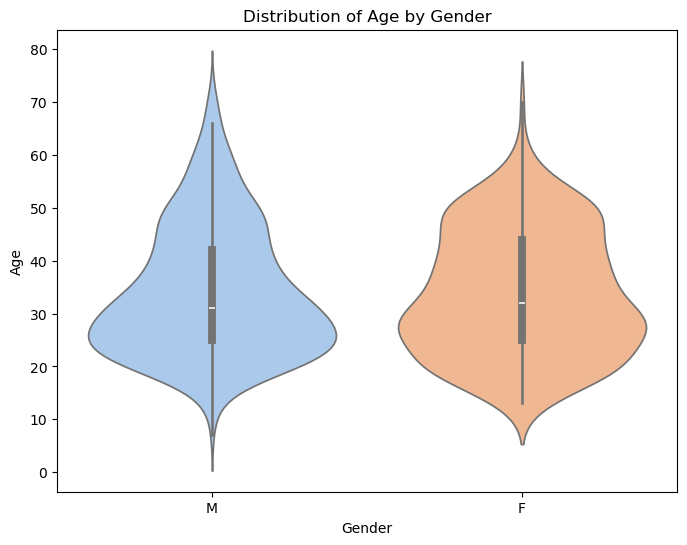

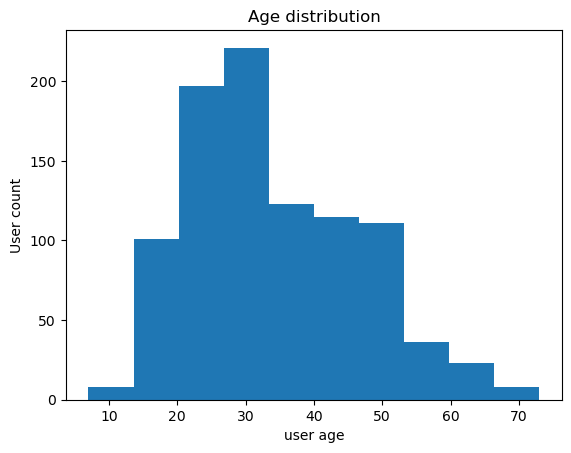

In [70]:
# Create the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(x='gender', y='age', data=uUser, palette='pastel', legend=False, hue = 'gender')

# Add titles and labels
plt.title('Distribution of Age by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.show()

plt.hist(uUser.drop(columns = 'gender'))
plt.title('Age distribution')
plt.ylabel('User count')
plt.xlabel('user age')
plt.show()

In [26]:
def getUserSimilarity(user1, user2, maxAgeDiff):
    normalisedAge = 1- (user1['age'] - user2['age']) / maxAgeDiff
    if (user1.gender == user2.gender):
        return normalisedAge
    else:
        return (0.8 * normalisedAge)
    

In [39]:
# uUser
maxAge = uUser.age.max()
minAge = uUser.age.min()
maxAgeDiff =maxAge - minAge
print(getUserSimilarity(uUser.loc[15], uUser.loc[98], maxAgeDiff))

1.0
